# REINFORCE

## 1. 相关概念

#### 策略网络 (policy network):

使用神经网络$\pi(a \mid s; \theta)$近似策略函数$\pi(a \mid s) = \mathbb{P}(A = a \mid S = s)$。

#### 策略学习 (policy-based reinforcement learning):

策略学习的目标是找到一个最优策略 $\pi$，使得累积奖励的期望值最大化。该目标可以描述为优化问题：$\max_\theta J(\theta)$，其中 $J(\theta) = \mathbb{E}[V_\pi(S)]$ 是状态价值函数的期望。

## 2. 策略梯度定理

$$\frac{\partial J(\theta)}{\partial \theta} = \mathbb{E}_S\left[ \mathbb{E}_{A \sim \pi(\cdot \mid S; \theta)} \left[ \frac{\partial \ln \pi(A \mid S; \theta)}{\partial \theta} \cdot Q_\pi(S, A) \right]\right]$$

粗略证明:

$$
\begin{aligned}
    V_\pi(s) & = \mathbb{E}_{A \sim \pi(\cdot \mid s; \theta)}\left[ Q_\pi(s, A) \right] \\
    & = \sum_{a \in \mathcal{A}} \pi(a \mid s; \theta) \cdot Q_\pi(s, a)
\end{aligned}
$$

状态价值函数关于$\theta$的梯度:

$$
\begin{aligned}
    \frac{\partial V_\pi(s)}{\partial \theta} & = \sum_{a \in \mathcal{A}}\frac{\partial \pi(a \mid s; \theta) \cdot Q_\pi(s, a)}{\partial \theta} \\
    & = \sum_{a \in \mathcal{A}}\frac{\partial \pi(a \mid s; \theta)}{\partial \theta} \cdot Q_\pi(s, a) + \sum_{a \in \mathcal{A}} \pi(a \mid s; \theta) \cdot \frac{\partial Q_\pi(s, a)}{\partial \theta} \\
    & = \sum_{a \in \mathcal{A}}\frac{\partial \pi(a \mid s; \theta)}{\partial \theta} \cdot Q_\pi(s, a) + \mathbb{E}_{A \sim \pi(\cdot \mid s; \theta)} \left[ \frac{\partial Q_\pi(s, a)}{\partial \theta} \right] \\
\end{aligned}
$$

保留第一项，忽略第二项：

$$
\begin{aligned}
    \frac{\partial V_\pi(s)}{\partial \theta} & = \sum_{a \in \mathcal{A}}\frac{\partial \pi(a \mid s; \theta)}{\partial \theta} \cdot Q_\pi(s, a) \\
    & = \sum_{a \in \mathcal{A}} \pi(a \mid s; \theta) \cdot \frac{1}{\pi(a \mid s; \theta)} \cdot \frac{\partial \pi(a \mid s; \theta)}{\partial \theta} \cdot Q_\pi(s, a) \\
    & = \sum_{a \in \mathcal{A}} \pi(a \mid s; \theta) \cdot \frac{\partial \ln \pi(a \mid s; \theta)}{\partial \theta} \cdot Q_\pi(s, a) \\
    & = \mathbb{E}_{a \sim \pi(\cdot \mid s; \theta)} \left[ \frac{\partial \ln \pi(a \mid s; \theta)}{\partial \theta} \cdot Q_\pi(s, a) \right]
\end{aligned}
$$

对状态求期望，可得:

$$
    \frac{\partial J(\theta)}{\partial \theta} = \mathbb{E}_S\left[ \mathbb{E}_{A \sim \pi(\cdot \mid S; \theta)} \left[ \frac{\partial \ln \pi(A \mid S; \theta)}{\partial \theta} \cdot Q_\pi(S, A) \right]\right]
$$

## 3. 近似策略梯度

在实际应用中，随机抽样一个动作 $a \sim \pi(\cdot \mid s; \theta)$，计算随机梯度 $g(s, a) = Q_\pi(s, a) \cdot \frac{\partial \ln \pi(a \mid s; \theta)}{\partial \theta}$ 是对策略梯度 $\frac{\partial J(\theta)}{\partial \theta}$ 的无偏估计。

## 4. REINFORCE

由于折扣回报 $U_t = \sum_{k=t}^n \gamma^{k-t} \cdot R_k$，动作价值函数 $Q_\pi(s_t, a_t) = \mathbb{E}[U_t \mid S_t = s_t, A_t = a_t]$。REINFORCE 算法通过在时刻 $t$ 让智能体完成一回合的交互，收集奖励 $r_t, \cdots, r_n$，计算 $u_t = \sum_{k=t}^n \gamma^{k-t} \cdot r_k$。则 $\tilde{g}(s_t, a_t; \theta) = u_t \cdot \frac{\partial \ln \pi (a_t \mid s_t; \theta)}{\partial \theta}$ 是对策略梯度的无偏估计。

## 5. 训练流程

设策略网络的当前参数为$\theta_{now}$。

(1) 收集一回合的轨迹$s_1, a_1, r_1, s_2, a_2, r_2, \cdots, s_n, a_n, r_n$;

(2) 计算回报: $u_t = \sum_{k=t}^n \gamma^{k-t} \cdot r_k, \forall t = 1, \cdots, n$;

(3) 反向传播: $\Delta_\theta \ln \pi(a_t \mid s_t; \theta_{now}), \forall t = 1, \cdots, n$;

(4) 更新参数: $\theta_{new} = \theta_{now} + \beta \cdot \sum_{t=1}^n u_t \cdot \Delta_\theta \ln \pi (a_t \mid s_t; \theta_{now})$.

# 代码实现

In [1]:
# 导入库
import os
import gym
import argparse
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter

In [2]:
# 定义策略网络
class PolicyNet(nn.Module):
    def __init__(self, state_size, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_actions)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        prob = F.softmax(x, dim=-1)
        return prob

In [3]:
# 定义REINFORCE类
class REINFORCE:
    def __init__(self, state_size, num_actions, discount, device):
        self.discount = discount
        self.device = device
        self.pi = PolicyNet(state_size, num_actions).to(device)
        
    def get_action(self, state):
        # state: (state_size,)
        # prob, m: (num_actions,)
        prob = self.pi(state)
        m = Categorical(prob)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob
    
    def compute_policy_loss(self, blogp, br):
        # blogp, br: (batch_size,)
        R = 0
        ut = []
        for r in reversed(br):
            R = r + self.discount * R
            ut.insert(0, R)
        bu = torch.tensor(ut, device=self.device)
        policy_loss = -torch.mean(blogp * bu)
        return policy_loss

In [4]:
# 定义Rollout类
class Rollout:
    def __init__(self, device):
        self.device = device
        self.bs = []
        self.ba = []
        self.blogp = []
        self.br = []
        self.bd = []
        self.bns = []
    
    def push(self, state, action, logp, reward, done, next_state):
        self.bs.append(state)
        self.ba.append(action)
        self.blogp.append(logp)
        self.br.append(reward)
        self.bd.append(done)
        self.bns.append(next_state)
        
    def tensor(self):
        bs = torch.as_tensor(self.bs, dtype=torch.float32, device=self.device)
        ba = torch.as_tensor(self.ba, dtype=torch.long, device=self.device)  
        blogp = torch.stack(self.blogp).to(self.device)  
        br = torch.as_tensor(self.br, dtype=torch.float32, device=self.device)
        bd = torch.as_tensor(self.bd, dtype=torch.float32, device=self.device)
        bns = torch.as_tensor(self.bns, dtype=torch.float32, device=self.device)
        return bs, ba, blogp, br, bd, bns
    
    def clear(self):
        self.bs = []
        self.ba = []
        self.blogp = []
        self.br = []
        self.bd = []
        self.bns = []

In [5]:
# 训练
def train(args, env):
    agent = REINFORCE(args.state_size, args.num_actions, args.discount, args.device)
    rollout = Rollout(args.device)
    pi_optimizer = torch.optim.Adam(agent.pi.parameters(), lr=args.lr)
    writer = SummaryWriter()
    
    episode_reward = 0
    episode_length = 0
    episode_num = 0
    max_episode_reward = -float('inf')
    
    agent.pi.train()
    state, _ = env.reset()
    
    for i in range(args.max_steps):
        action, log_prob = agent.get_action(torch.tensor(state, dtype=torch.float32, device=args.device))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        rollout.push(state, action, log_prob, reward, done, next_state)
        episode_reward += reward
        episode_length += 1
        state = next_state
        
        if done:
            bs, ba, blogp, br, bd, bns = rollout.tensor()    
            policy_loss = agent.compute_policy_loss(blogp, br)
            pi_optimizer.zero_grad()
            policy_loss.backward()
            pi_optimizer.step()
            
            if episode_reward >= max_episode_reward:
                max_episode_reward = episode_reward
                save_path = os.path.join(args.output_dir, 'model.bin')
                torch.save(agent.pi.state_dict(), save_path)
            
            writer.add_scalar('Maximum reward', max_episode_reward, episode_num)
            writer.add_scalar('Episode reward', episode_reward, episode_num)
            writer.add_scalar('Episode length', episode_length, episode_num)
            print(f'step = {i}, reward = {episode_reward:.0f}, length = {episode_length}, max reward = {max_episode_reward}')
                     
            episode_reward = 0
            episode_length = 0
            episode_num += 1
            state, _ = env.reset()
            rollout.clear()
    
    writer.close()

In [6]:
# 测试
def eval(args, env):
    agent = REINFORCE(args.state_size, args.num_actions, args.discount, args.device)
    model_path = os.path.join(args.output_dir, 'model.bin')
    agent.pi.load_state_dict(torch.load(model_path))
    agent.pi.to(args.device)
    agent.pi.eval()
    
    episode_reward = 0
    episode_length = 0
    state, _ = env.reset()
    for _ in range(5000):
        action, _ = agent.get_action(torch.tensor(state, dtype=torch.float32, device=args.device))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
        state = next_state
        
        if done:
            state, _ = env.reset()
            print(f'episode reward = {episode_reward:.0f}, episode length = {episode_length}')
            episode_reward = 0
            episode_length = 0

In [7]:
# 运行
args = argparse.Namespace()
args.env = 'CartPole-v1'
args.state_size = 4
args.num_actions = 2
args.discount = 0.99
args.max_steps = int(1e5)
args.lr = 3e-3
args.output_dir = 'output'
if torch.cuda.is_available():
    args.device = torch.device('cuda')
else:
    args.device = torch.device('cpu')
    
os.makedirs(args.output_dir, exist_ok=True)
    
env = gym.make(args.env)
env.reset(seed=42)
env.action_space.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if args.device == torch.device('cuda'):
    torch.cuda.manual_seed(42)
print('Training started...')
train(args, env)
print('Training completed!')

print('Evaluation started...')
eval(args, env)
print('Evaluation completed!')

Training started...
step = 15, reward = 16, length = 16, max reward = 16.0
step = 37, reward = 22, length = 22, max reward = 22.0
step = 55, reward = 18, length = 18, max reward = 22.0
step = 82, reward = 27, length = 27, max reward = 27.0
step = 96, reward = 14, length = 14, max reward = 27.0
step = 111, reward = 15, length = 15, max reward = 27.0
step = 138, reward = 27, length = 27, max reward = 27.0
step = 170, reward = 32, length = 32, max reward = 32.0
step = 194, reward = 24, length = 24, max reward = 32.0
step = 245, reward = 51, length = 51, max reward = 51.0
step = 272, reward = 27, length = 27, max reward = 51.0
step = 283, reward = 11, length = 11, max reward = 51.0
step = 311, reward = 28, length = 28, max reward = 51.0
step = 330, reward = 19, length = 19, max reward = 51.0
step = 367, reward = 37, length = 37, max reward = 51.0
step = 379, reward = 12, length = 12, max reward = 51.0
step = 398, reward = 19, length = 19, max reward = 51.0
step = 411, reward = 13, length =

/Users/xavier/PythonCode/venv/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)


step = 514, reward = 15, length = 15, max reward = 51.0
step = 536, reward = 22, length = 22, max reward = 51.0
step = 549, reward = 13, length = 13, max reward = 51.0
step = 630, reward = 81, length = 81, max reward = 81.0
step = 641, reward = 11, length = 11, max reward = 81.0
step = 662, reward = 21, length = 21, max reward = 81.0
step = 689, reward = 27, length = 27, max reward = 81.0
step = 701, reward = 12, length = 12, max reward = 81.0
step = 717, reward = 16, length = 16, max reward = 81.0
step = 734, reward = 17, length = 17, max reward = 81.0
step = 780, reward = 46, length = 46, max reward = 81.0
step = 810, reward = 30, length = 30, max reward = 81.0
step = 830, reward = 20, length = 20, max reward = 81.0
step = 860, reward = 30, length = 30, max reward = 81.0
step = 884, reward = 24, length = 24, max reward = 81.0
step = 895, reward = 11, length = 11, max reward = 81.0
step = 928, reward = 33, length = 33, max reward = 81.0
step = 947, reward = 19, length = 19, max reward

step = 5669, reward = 26, length = 26, max reward = 126.0
step = 5691, reward = 22, length = 22, max reward = 126.0
step = 5706, reward = 15, length = 15, max reward = 126.0
step = 5733, reward = 27, length = 27, max reward = 126.0
step = 5759, reward = 26, length = 26, max reward = 126.0
step = 5784, reward = 25, length = 25, max reward = 126.0
step = 5805, reward = 21, length = 21, max reward = 126.0
step = 5859, reward = 54, length = 54, max reward = 126.0
step = 5889, reward = 30, length = 30, max reward = 126.0
step = 5920, reward = 31, length = 31, max reward = 126.0
step = 5945, reward = 25, length = 25, max reward = 126.0
step = 5972, reward = 27, length = 27, max reward = 126.0
step = 6009, reward = 37, length = 37, max reward = 126.0
step = 6079, reward = 70, length = 70, max reward = 126.0
step = 6105, reward = 26, length = 26, max reward = 126.0
step = 6134, reward = 29, length = 29, max reward = 126.0
step = 6164, reward = 30, length = 30, max reward = 126.0
step = 6188, r

step = 22082, reward = 71, length = 71, max reward = 500.0
step = 22134, reward = 52, length = 52, max reward = 500.0
step = 22197, reward = 63, length = 63, max reward = 500.0
step = 22301, reward = 104, length = 104, max reward = 500.0
step = 22371, reward = 70, length = 70, max reward = 500.0
step = 22435, reward = 64, length = 64, max reward = 500.0
step = 22463, reward = 28, length = 28, max reward = 500.0
step = 22522, reward = 59, length = 59, max reward = 500.0
step = 22618, reward = 96, length = 96, max reward = 500.0
step = 22641, reward = 23, length = 23, max reward = 500.0
step = 22725, reward = 84, length = 84, max reward = 500.0
step = 22780, reward = 55, length = 55, max reward = 500.0
step = 22815, reward = 35, length = 35, max reward = 500.0
step = 22845, reward = 30, length = 30, max reward = 500.0
step = 22869, reward = 24, length = 24, max reward = 500.0
step = 22901, reward = 32, length = 32, max reward = 500.0
step = 22926, reward = 25, length = 25, max reward = 5

step = 37047, reward = 12, length = 12, max reward = 500.0
step = 37060, reward = 13, length = 13, max reward = 500.0
step = 37071, reward = 11, length = 11, max reward = 500.0
step = 37082, reward = 11, length = 11, max reward = 500.0
step = 37092, reward = 10, length = 10, max reward = 500.0
step = 37104, reward = 12, length = 12, max reward = 500.0
step = 37117, reward = 13, length = 13, max reward = 500.0
step = 37128, reward = 11, length = 11, max reward = 500.0
step = 37137, reward = 9, length = 9, max reward = 500.0
step = 37149, reward = 12, length = 12, max reward = 500.0
step = 37160, reward = 11, length = 11, max reward = 500.0
step = 37169, reward = 9, length = 9, max reward = 500.0
step = 37181, reward = 12, length = 12, max reward = 500.0
step = 37189, reward = 8, length = 8, max reward = 500.0
step = 37201, reward = 12, length = 12, max reward = 500.0
step = 37213, reward = 12, length = 12, max reward = 500.0
step = 37224, reward = 11, length = 11, max reward = 500.0
ste

step = 39767, reward = 25, length = 25, max reward = 500.0
step = 39792, reward = 25, length = 25, max reward = 500.0
step = 39820, reward = 28, length = 28, max reward = 500.0
step = 39853, reward = 33, length = 33, max reward = 500.0
step = 39901, reward = 48, length = 48, max reward = 500.0
step = 39930, reward = 29, length = 29, max reward = 500.0
step = 39955, reward = 25, length = 25, max reward = 500.0
step = 39981, reward = 26, length = 26, max reward = 500.0
step = 40000, reward = 19, length = 19, max reward = 500.0
step = 40041, reward = 41, length = 41, max reward = 500.0
step = 40071, reward = 30, length = 30, max reward = 500.0
step = 40104, reward = 33, length = 33, max reward = 500.0
step = 40136, reward = 32, length = 32, max reward = 500.0
step = 40174, reward = 38, length = 38, max reward = 500.0
step = 40223, reward = 49, length = 49, max reward = 500.0
step = 40258, reward = 35, length = 35, max reward = 500.0
step = 40281, reward = 23, length = 23, max reward = 500

step = 63627, reward = 275, length = 275, max reward = 500.0
step = 63906, reward = 279, length = 279, max reward = 500.0
step = 64137, reward = 231, length = 231, max reward = 500.0
step = 64311, reward = 174, length = 174, max reward = 500.0
step = 64543, reward = 232, length = 232, max reward = 500.0
step = 64764, reward = 221, length = 221, max reward = 500.0
step = 64956, reward = 192, length = 192, max reward = 500.0
step = 65151, reward = 195, length = 195, max reward = 500.0
step = 65523, reward = 372, length = 372, max reward = 500.0
step = 65709, reward = 186, length = 186, max reward = 500.0
step = 66203, reward = 494, length = 494, max reward = 500.0
step = 66445, reward = 242, length = 242, max reward = 500.0
step = 66844, reward = 399, length = 399, max reward = 500.0
step = 67332, reward = 488, length = 488, max reward = 500.0
step = 67507, reward = 175, length = 175, max reward = 500.0
step = 67963, reward = 456, length = 456, max reward = 500.0
step = 68430, reward = 4

episode reward = 500, episode length = 500
episode reward = 500, episode length = 500
episode reward = 190, episode length = 190
episode reward = 490, episode length = 490
episode reward = 500, episode length = 500
episode reward = 495, episode length = 495
episode reward = 500, episode length = 500
episode reward = 500, episode length = 500
episode reward = 500, episode length = 500
episode reward = 500, episode length = 500
Evaluation completed!


#### Reward:
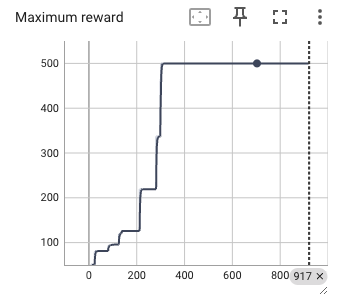

#### Maximum reward:
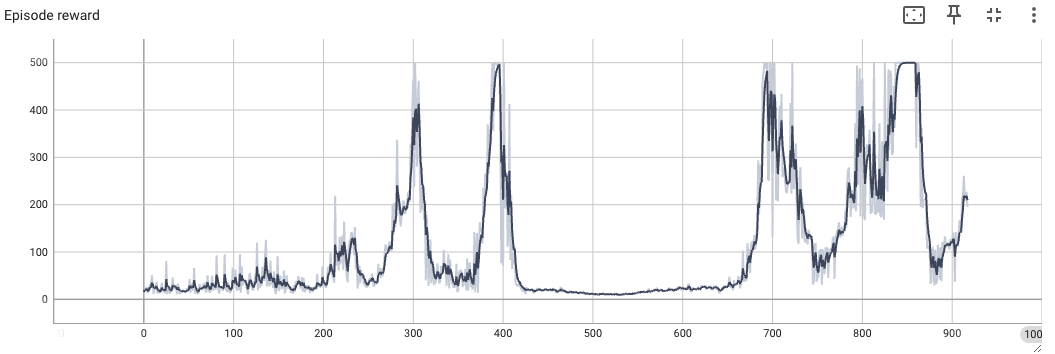